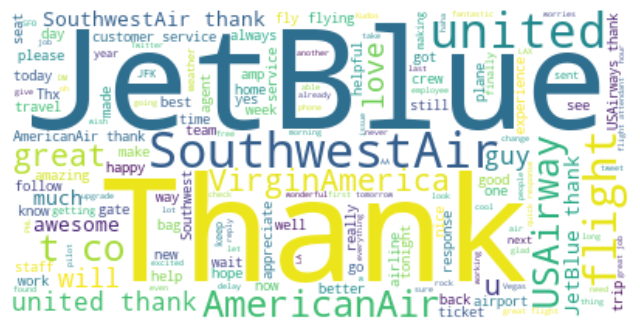

In [4]:
# STAT 574 HW4 Problem 7

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from simpletransformers.classification import ClassificationModel

air_data = pd.read_csv("C:/Users/coryg/OneDrive/Desktop/STAT_574_Data_Mining/hw4STAT574S25/USAirlinesTweets.csv")
air_data.drop_duplicates(subset=['tweet'], keep='first', inplace=True)
text = " ".join([x for x in air_data.tweet[air_data.sentiment == 'positive']])

# Positive Tweets

# Plotting wordclouds for positive news

text = " ".join([x for x in air_data.tweet[air_data.sentiment == 'positive']])
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

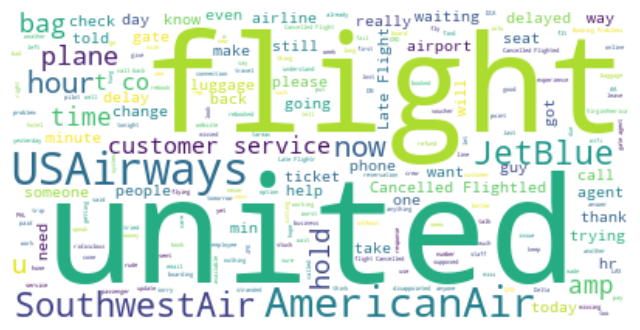

In [5]:
# Negative Tweets

# Plotting wordcloud for negative tweets

text = " ".join([x for x in air_data.tweet[air_data.sentiment == 'negative']])
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\simpletransformers\classification\classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Epoch 1 of 1:   0%|          | 0/1 [18:14<?, ?it/s]


KeyboardInterrupt: 

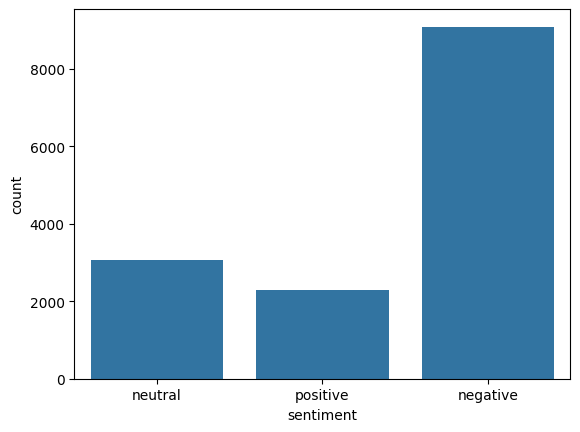

In [6]:
# Plotting bar graph for sentiments. 

sns.countplot(x = air_data['sentiment'])
air_data['sentiment'].value_counts()

# Training model

train, test = train_test_split(air_data, test_size=0.2, random_state=576574)

bert_model = ClassificationModel('bert', 'bert-base-cased', num_labels=3,
        args={'reprocess_input_data': True, 'overwrite_output_dir': True},
        use_cuda=False)

def making_label(st):
    if (st=='positive'):
        return 0
    elif (st=='neutral'):
        return 2
    else:
        return 1
    
train['label'] = train['sentiment'].apply(making_label)
test['label'] = test['sentiment'].apply(making_label)

train_df = pd.DataFrame({
    'text': train['tweet'][:6000].replace(r'\n', '', regex=True),
    'label': train['label'][:6000]
})

eval_df = pd.DataFrame({
    'text': train['tweet'][-1000:].replace(r'\n', '', regex=True),
    'label': test['label'][-1000:]
})
bert_model.train_model(train_df)

In [ ]:
# Computing predicted sentiments for testing set. 

result, model_outputs, wrong_predictions = bert_model.eval_model(eval_df)
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

truth = eval_df['label'].tolist()
predicted = lst

# Displaying confusion matrix. 

conf_mat = confusion_matrix(truth, predicted)
print(conf_mat)

# Displaying heatmap for confusion matrix. 

df_cm = pd.DataFrame(conf_mat, ['positive', 'negative', 'neutral'], ['positive', 'negative', 'neutral'])
sns.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# Displaying performance metrics

print(classification_report(truth, predicted, target_names=['positive', 'negative', 'neutral']))
print(accuracy_score(truth, predicted))

In [ ]:
# Using trained model to classify user-defined sentences. 

def classify(statement):
    result = bert_model.predict([statement])
    pred_class = np.where(result[1][0] == np.amax(result[1][0]))
    pred_class = int(pred_class[0])
    sentiment_dict = {0: "Positive", 1: "Negative", 2: "Neutral"}
    print(sentiment_dict[pred_class])
    return

classify("I am afraid of flying on planes.")
classify("The captain was very friendly and understanding.")
classify("Riding on a plane today.")

In [ ]:
# Training a Bert based model on negative tweets and computing prediction accuracy
# for reasons of negative tweets. Testing on mock tweets. 

negative_tweets = air_data[air_data.sentiment == 'negative']
negative_tweets = negative_tweets.drop('sentiment', axis=1)
negative_tweets['negativereason'].value_counts()

negative_reasons = negative_tweets['negativereason'].unique()

train, test = train_test_split(negative_tweets, test_size=0.2, random_state=432648)

neg_bert = ClassificationModel('bert', 'bert-base-cased', num_labels=10,
                               args={'reprocess_input_data': True, 'overwrite_output_dir':True},
                               use_cuda=False)

def making_label(st):
    if (st == "Bad Flight"):
        return 0
    if (st == "Can't Tell"):
        return 1
    if (st == "Late Flight"):
        return 2
    if (st == "Customer Service Issue"):
        return 3
    if (st == "Flight Booking Problems"):
        return 4
    if (st == "Lost Luggage"):
        return 5
    if (st == "Flight Attendant Complaints"):
        return 6
    if (st == "Cancelled Flight"):
        return 7
    if (st == "Damaged Luggage"):
        return 8
    if (st == "longlines"):
        return 9

train['label'] = train['negativereason'].apply(making_label)
test['label'] = test['negativereason'].apply(making_label)

train_df = pd.DataFrame({
    'text': train['tweet'][:3500].replace(r'\n', ' ', regex=True),
    'label': train['label'][:3500]
})

eval_df = pd.DataFrame({
    'text': test['tweet'][-900:].replace(r'\n', ' ', regex=True),
    'label': test['label'][-900]
})

neg_bert.train_model(train_df)

In [ ]:
# Computing predicted sentiments for testing set. 

result, model_outputs, wrong_predictions = neg_bert.eval_model(eval_df)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

truth = eval_df['label'].tolist()
predicted = lst

# Computing predicted accuracy 

print(accuracy_score(truth, predicted))

def classify(statement):
    result = neg_bert.predict([statement])
    pred_class = np.where(result[1][0] == np.amax(result[1][0]))
    pred_class = int(pred_class[0])
    sentiment_dict = {0: "Bad Flight", 1: "Can't Tell", 2: "Late Flight", 3: "Customer Service Issue",
                      4: "Flight Booking Problems", 5: "Lost Luggage", 6: "Flight Attendant Complaints",
                      7: "Cancelled Flight", 8: "Damaged Luggage", 9: "longlines"}
    print(sentiment_dict[pred_class])
    return

classify('The staff were rude and disrespectful.')
classify('The lines were so long and time consuming.')
classify('My luggage got lost and was found damaged.')